In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [32]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20

# 📐 Input shape
input_shape = (IMG_SIZE, IMG_SIZE, 3)


In [33]:
# 🧱 Branch builder
def build_branch(input_shape, branch_name):
    input_layer = Input(shape=input_shape, name=f'{branch_name}_input')
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name=f'{branch_name}_conv1')(input_layer)
    x = MaxPooling2D(2, 2, name=f'{branch_name}_pool1')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name=f'{branch_name}_conv2')(x)
    x = MaxPooling2D(2, 2, name=f'{branch_name}_pool2')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name=f'{branch_name}_conv3')(x)
    x = MaxPooling2D(2, 2, name=f'{branch_name}_pool3')(x)

    x = Flatten(name=f'{branch_name}_flatten')(x)
    return input_layer, x
# 🧠 Build branches
rgb_input, rgb_features = build_branch(input_shape, 'rgb')
ela_input, ela_features = build_branch(input_shape, 'ela')
fft_input, fft_features = build_branch(input_shape, 'fft')
# 🔗 Merge branches
merged = concatenate([rgb_features, ela_features, fft_features], name='merged_features')
x = Dense(256, activation='relu')(merged)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

In [34]:
model = Model(inputs=[rgb_input, ela_input, fft_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fft_input           │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_conv1 (Conv2D)  │ (None, 128, 128,  │        896 │ rgb_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_conv1 (Conv2D)  │ (None, 128, 128,  │        896 │ ela_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fft_conv1 (Conv2D)  │ (None, 128, 128,  │        896 │ fft_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_pool1           │ (None, 64, 64,    │          0 │ rgb_conv1[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_pool1           │ (None, 64, 64,    │          0 │ ela_conv1[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fft_pool1           │ (None, 64, 64,    │          0 │ fft_conv1[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_conv2 (Conv2D)  │ (None, 64, 64,    │     18,496 │ rgb_pool1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_conv2 (Conv2D)  │ (None, 64, 64,    │     18,496 │ ela_pool1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fft_conv2 (Conv2D)  │ (None, 64, 64,    │     18,496 │ fft_pool1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_pool2           │ (None, 32, 32,    │          0 │ rgb_conv2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_pool2           │ (None, 32, 32,    │          0 │ ela_conv2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fft_pool2           │ (None, 32, 32,    │          0 │ fft_conv2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rgb_conv3 (Conv2D)  │ (None, 32, 32,    │     73,856 │ rgb_pool2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ela_conv3 (Conv2D)  │ (None, 32, 32,    │     73,856 │ ela_pool2[0][0] 

 Total params: 25,462,337 (97.13 MB)

 Trainable params: 25,462,337 (97.13 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# 🗂️ Load image data from directory
import glob

def load_images_from_subfolders(base_path):
    images = []
    labels = []
    for label in ['real', 'fake']:
        for subset in ['Train', 'Validation']:
            class_dir = os.path.join(base_path, subset, label)
            image_paths = glob.glob(os.path.join(class_dir, '*.jpg'))
            for img_path in image_paths:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img = img.astype('float32') / 255.0
                    images.append(img)
                    labels.append(0 if label == 'real' else 1)
    return np.array(images), np.array(labels)

# ✅ Load RGB, ELA, FFT images correctly using the fixed function and correct path
rgb_images, labels = load_images_from_subfolders(r'C:\Users\yuvip\OneDrive\Desktop\mini_project\data\preprocessed\rpg')
ela_images, _ = load_images_from_subfolders(r'C:\Users\yuvip\OneDrive\Desktop\mini_project\data\preprocessed\ela')
fft_images, _ = load_images_from_subfolders(r'C:\Users\yuvip\OneDrive\Desktop\mini_project\data\preprocessed\fft')
print(f"Loaded RGB: {len(rgb_images)}")
print(f"Loaded ELA: {len(ela_images)}")
print(f"Loaded FFT: {len(fft_images)}")
print(f"Labels: {len(labels)}")


# 🔀 Train/val split
X_train_rgb, X_val_rgb, X_train_ela, X_val_ela, X_train_fft, X_val_fft, y_train, y_val = train_test_split(
    rgb_images, ela_images, fft_images, labels, test_size=0.2, random_state=42
)


Loaded RGB: 17000
Loaded ELA: 17000
Loaded FFT: 17000
Labels: 17000


In [ ]:
# Define EarlyStopping callback to stop training early if validation loss isn't improving
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    [X_train_rgb, X_train_ela, X_train_fft],
    y_train,
    validation_data=([X_val_rgb, X_val_ela, X_val_fft], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.6125 - loss: 0.6451

425/425 ━━━━━━━━━━━━━━━━━━━━ 362s 830ms/step - accuracy: 0.6127 - loss: 0.6449 - val_accuracy: 0.8024 - val_loss: 0.4296
Epoch 2/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.7939 - loss: 0.4464

425/425 ━━━━━━━━━━━━━━━━━━━━ 337s 792ms/step - accuracy: 0.7940 - loss: 0.4463 - val_accuracy: 0.8338 - val_loss: 0.3644
Epoch 3/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.8359 - loss: 0.3757

425/425 ━━━━━━━━━━━━━━━━━━━━ 334s 785ms/step - accuracy: 0.8359 - loss: 0.3757 - val_accuracy: 0.8459 - val_loss: 0.3384
Epoch 4/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.8514 - loss: 0.3444

425/425 ━━━━━━━━━━━━━━━━━━━━ 335s 787ms/step - accuracy: 0.8514 - loss: 0.3444 - val_accuracy: 0.8565 - val_loss: 0.3180
Epoch 5/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 323s 760ms/step - accuracy: 0.8727 - loss: 0.3058 - val_accuracy: 0.8585 - val_loss: 0.3275
Epoch 6/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.8832 - loss: 0.2798

425/425 ━━━━━━━━━━━━━━━━━━━━ 313s 735ms/step - accuracy: 0.8832 - loss: 0.2798 - val_accuracy: 0.8776 - val_loss: 0.2835
Epoch 7/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9037 - loss: 0.2390

425/425 ━━━━━━━━━━━━━━━━━━━━ 313s 735ms/step - accuracy: 0.9037 - loss: 0.2390 - val_accuracy: 0.8835 - val_loss: 0.2693
Epoch 8/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 309s 728ms/step - accuracy: 0.9169 - loss: 0.2108 - val_accuracy: 0.8818 - val_loss: 0.2763
Epoch 9/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.9288 - loss: 0.1820

425/425 ━━━━━━━━━━━━━━━━━━━━ 310s 730ms/step - accuracy: 0.9288 - loss: 0.1820 - val_accuracy: 0.8956 - val_loss: 0.2538
Epoch 10/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 387s 911ms/step - accuracy: 0.9377 - loss: 0.1535 - val_accuracy: 0.8915 - val_loss: 0.2637
Epoch 11/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 384s 904ms/step - accuracy: 0.9526 - loss: 0.1223 - val_accuracy: 0.8891 - val_loss: 0.3096
Epoch 12/20
425/425 ━━━━━━━━━━━━━━━━━━━━ 387s 911ms/step - accuracy: 0.9579 - loss: 0.1107 - val_accuracy: 0.8891 - val_loss: 0.2980


In [38]:
model.save(r"C:\Users\yuvip\OneDrive\Desktop\mini_project\models\forensic_model.h5")


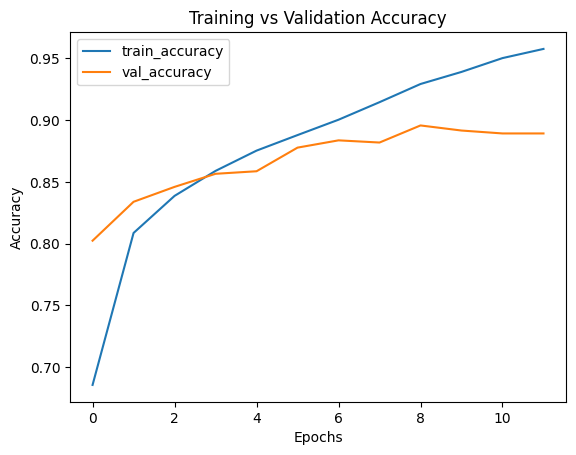

In [39]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()
